<a href="https://colab.research.google.com/github/dante3112/NetworkAnalysis/blob/master/IsolChrones_Delhi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx
!pip install plotly_express

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon


import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
from descartes import PolygonPatch

from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)
%matplotlib inline
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.14.0'

/usr/local/lib/python3.6/dist-packages/osmnx/projection.py:62: FutureWarning:

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.



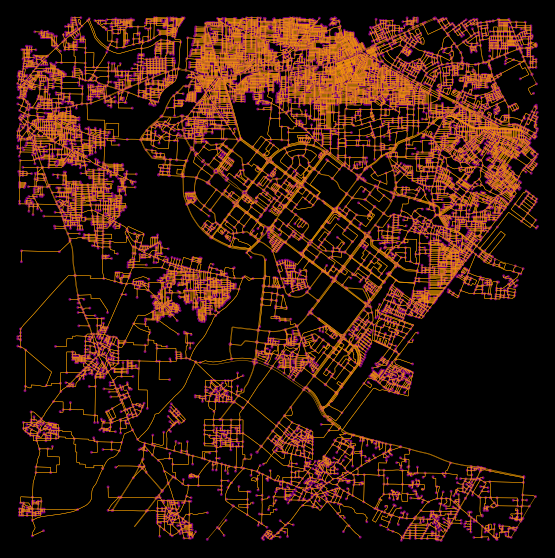

In [0]:
G = ox.graph_from_address('Dwarka, delhi', network_type='drive', simplify=True, dist=6000)
fig, ax = ox.plot_graph(G, fig_height=10, node_size=8, bgcolor='k',
                        edge_color='orange', node_color='purple', edge_linewidth=0.4)

In [0]:
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
# save as html file then display map as an iframe
filepath = 'Dwarka.html'
graph_map.save(filepath)
IFrame(filepath, width=900, height=500)

In [0]:
# Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

# Specify where you want to start and get nearest nodes. 
POI = ox.get_nearest_node(G, point=(28.583151, 77.037414))

# Project a graph from lat-long to the UTM zone appropriate for its geographic location.
G = ox.project_graph(G)

/usr/local/lib/python3.6/dist-packages/osmnx/projection.py:151: FutureWarning:

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.



In [0]:
trip_times = [5,10,15,20,25] #in minutes
travel_speed = 15 #in kmph
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

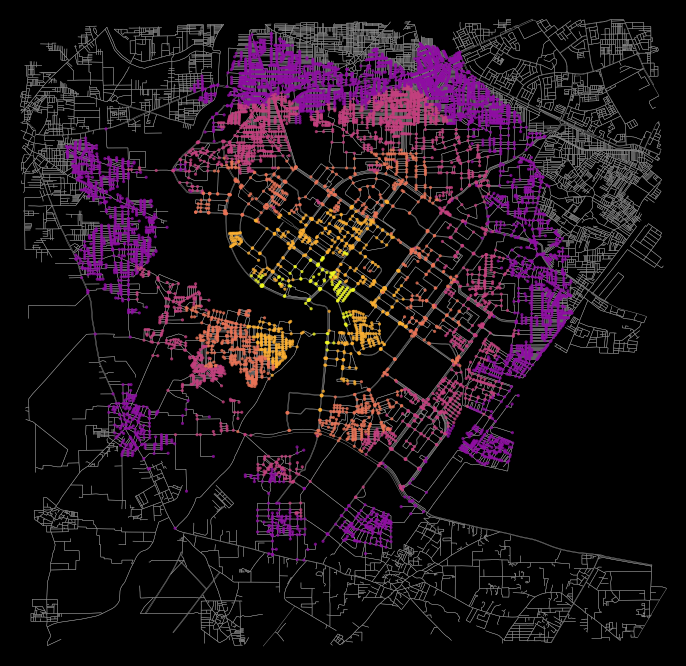

<Figure size 432x288 with 0 Axes>

In [0]:
# color the nodes according to isochrone then plot the street network
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0.3, return_hex=True)

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, POI, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
#fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, save=True, node_alpha=0.8, node_zorder=2)
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, save=True, node_zorder=2, bgcolor='k', edge_linewidth=0.4, edge_color='#999999',fig_height=12)
plt.savefig("iso1.png")


In [0]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, POI, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

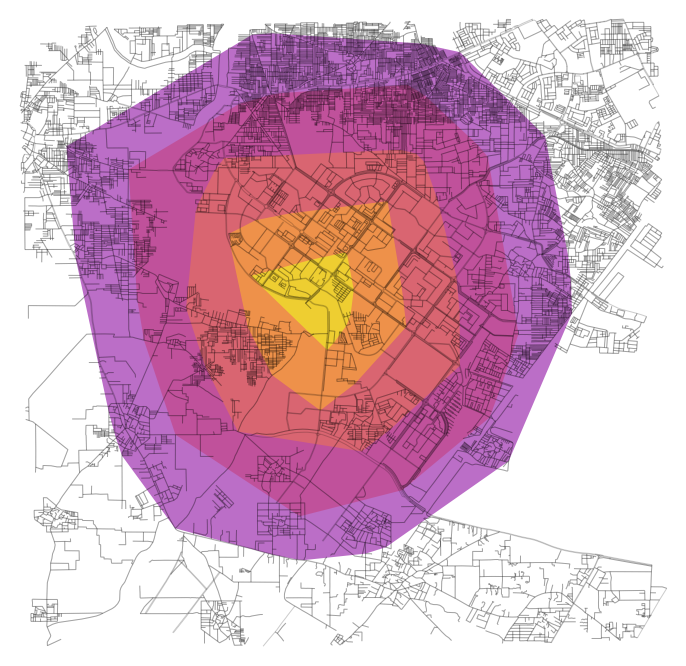

In [0]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2,
                        node_size=0, fig_height=12)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [0]:
gdf = gpd.GeoDataFrame({"time": trip_times}, geometry= isochrone_polys)
gdf.head()

,time,geometry
0,5,"POLYGON ((699186.470 3158505.759, 699059.403 3..."
1,10,"POLYGON ((699131.320 3159353.100, 699039.875 3..."
2,15,"POLYGON ((700270.672 3160594.749, 697949.406 3..."
3,20,"POLYGON ((699497.412 3161386.311, 699484.632 3..."
4,25,"POLYGON ((699622.958 3162545.121, 698383.971 3..."


In [0]:
gdf_edges = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
gdf_edges.head()

,u,v,key,osmid,highway,oneway,length,time,geometry,name,service,lanes,bridge,maxspeed,tunnel,ref,junction,access
0,4135714816,4140739121,0,797846476,residential,False,62.671,0.250684,"LINESTRING (699339.258 3157662.438, 699339.879...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4135714816,4140739121,1,412021392,residential,False,462.705,1.850820,"LINESTRING (699339.258 3157662.438, 699139.551...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4135714816,4132181665,0,797846476,residential,False,118.284,0.473136,"LINESTRING (699339.258 3157662.438, 699336.101...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4135714816,4135714820,0,797846473,residential,False,155.130,0.620520,"LINESTRING (699339.258 3157662.438, 699392.281...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4135714820,4135714816,0,797846473,residential,False,155.130,0.620520,"LINESTRING (699464.628 3157702.713, 699409.744...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
gdf_edges.crs, gdf_nodes.crs

(<Projected CRS: +proj=utm +zone=43 +ellps=WGS84 +datum=WGS84 +unit ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: UTM zone 43N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich, <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [0]:
gdf.crs = gdf_edges.crs
gdf.to_file("isopolys_z34.shp")
gdf.crs

<Projected CRS: +proj=utm +zone=43 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

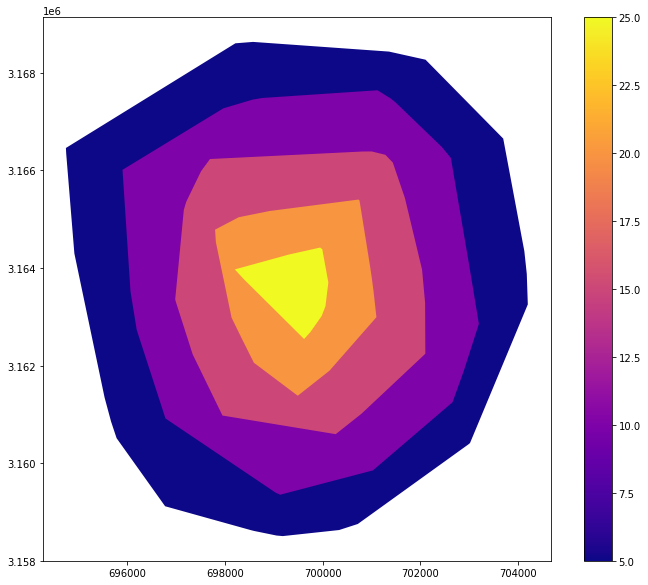

In [0]:
fig, ax = plt.subplots(figsize=(12,10))
gdf.plot(column="time", ax=ax, cmap="plasma", legend=True);